In [131]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from anndata import AnnData
import scanpy as sc
from os import path
import os
from rpy2.robjects.packages import importr
base = importr('base')
import numpy as np
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from tqdm import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import random
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
import gpzoo.pri_experiment_utilities as putil
import torch
from torch import optim, distributions, nn
import time

In [61]:
random.seed(256)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [62]:
root_path = "/engelhardt/home/pshrestha/vnngp/"
dpth = path.join(root_path, "data/")

In [63]:
merpath = path.join(dpth, "merfish.h5ad")

In [64]:
ad = sc.read_h5ad(merpath)

In [65]:
ad.var_names_make_unique()

In [66]:
#ad.var["mt"] = ad.var_names.str.startswith("mt-")
#sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
#ad = ad[ad.obs.pct_counts_mt < 20]
#sc.pp.filter_genes(ad, min_cells=1)
#sc.pp.filter_cells(ad, min_counts=100)
#ad.layers = {"counts":ad.X.copy()}

In [67]:
ad.X.shape

(21458, 3000)

In [68]:
ad.obs['orig.ident']

AAACCCAAGAGTCTTC_1      Batch-1
AAACCCAAGGACTTCT_1      Batch-1
AAACCCAGTCACCACG_1      Batch-1
AAACCCAGTCACTCTC_1      Batch-1
AAACCCAGTTCCTTGC_1      Batch-1
                         ...   
TTTGGAGGTCTTTCAT-1_4    Batch-4
TTTGGAGGTTTGGAAA-1_4    Batch-4
TTTGGTTCAGTGGCTC-1_4    Batch-4
TTTGGTTTCTTTACAC-1_4    Batch-4
TTTGTTGGTCGTCATA-1_4    Batch-4
Name: orig.ident, Length: 21458, dtype: object

In [69]:
len(ad.X)

21458

In [70]:
labels = ad.obs.Age.unique()

In [71]:
ad.obs['Age_cat'] = ad.obs['Age'].astype('category')

In [72]:
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
Y = np.array(ad.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = ad.obsm['X_harmony']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)

In [73]:
ad.uns['counts'] = ad.X.copy()

In [74]:
ad.var['deviance_poisson'] = deviancePoisson(ad.uns["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:622: RuntimeWarning: invalid value encountered in log
  ll_null = feature_sums*np.log(feature_sums/sz.sum())
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)


In [75]:
ad

View of AnnData object with n_obs × n_vars = 21458 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'nCount_LMO', 'nFeature_LMO', 'LMO_maxID', 'LMO_secondID', 'LMO_margin', 'LMO_classification', 'LMO_classification.global', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'Celltype', 'Celltype.LowRes', 'Age', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.5', 'SCT_snn_res.0.2', 'SCT_snn_res.0.1', 'SCT_snn_res.0.15', 'SCT_snn_res.0.18', 'SCT_snn_res.0.19', 'SCT_snn_res.0.17', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'Prolif_Lineage_Fraction_of_SVZ', 'Age_cat'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable', 'deviance_poisson'
    uns: 'counts'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'X_umap_har'
    varm: 'HARMONY', 'PCs'

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-pack

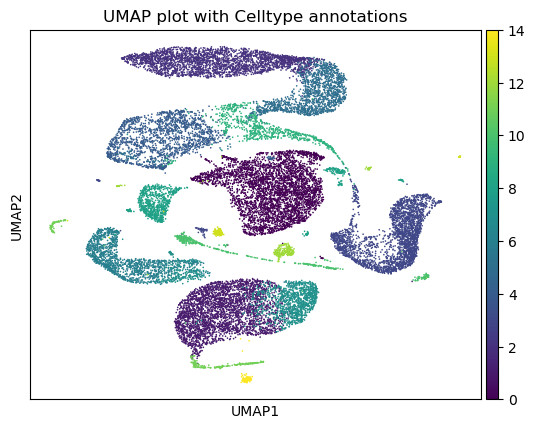

In [76]:
sc.pl.umap(ad, color='Celltype', title='UMAP plot with Celltype annotations', label=True) # looks same with Seurat clusters

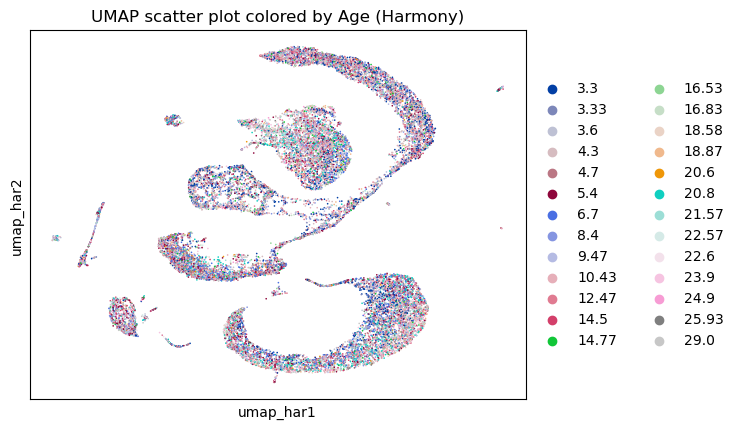

In [77]:
sc.pl.embedding(ad, basis='umap_har', color='Age_cat', title='UMAP scatter plot colored by Age (Harmony)', cmap='rocket')

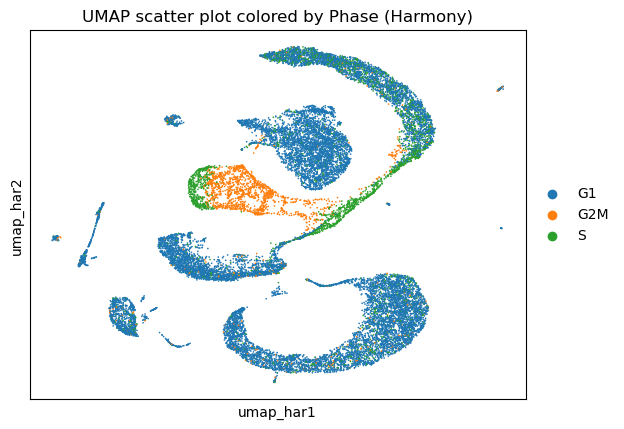

In [78]:
sc.pl.embedding(ad, basis='umap_har', color='Phase', title='UMAP scatter plot colored by Phase (Harmony)')

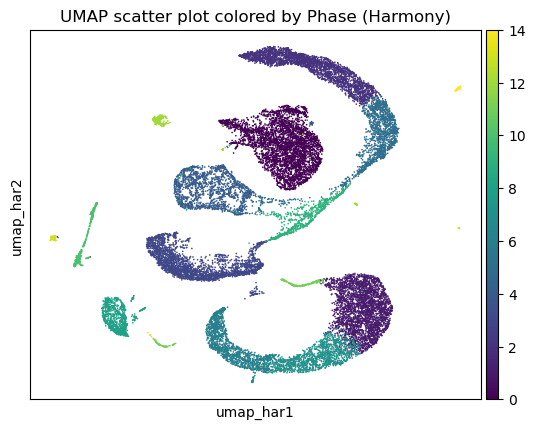

In [79]:
sc.pl.embedding(ad, basis='umap_har', color='Celltype', title='UMAP scatter plot colored by Phase (Harmony)')

Text(0.5, 1.0, 'Distribution of Ages')

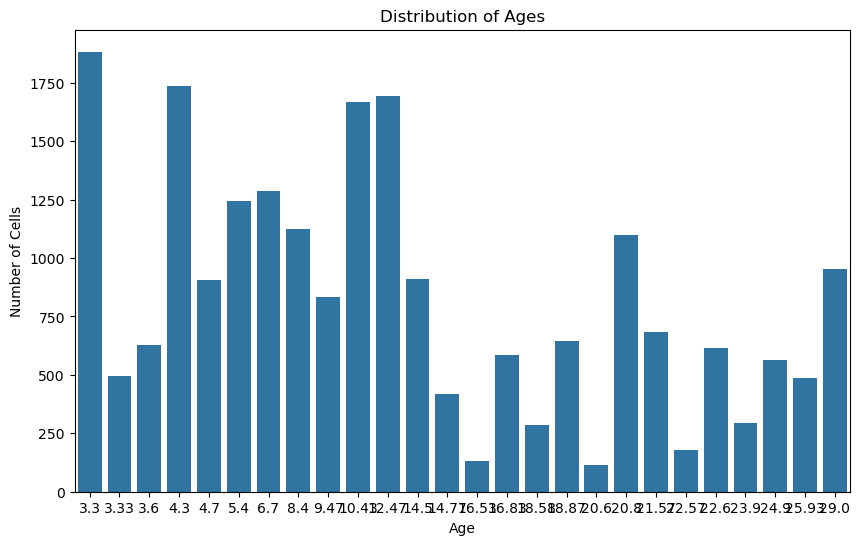

In [80]:
# Bar plot for age distribution
age_counts = ad.obs['Age'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=age_counts.index, y=age_counts.values)
plt.xlabel('Age')
plt.ylabel('Number of Cells')
plt.title('Distribution of Ages')

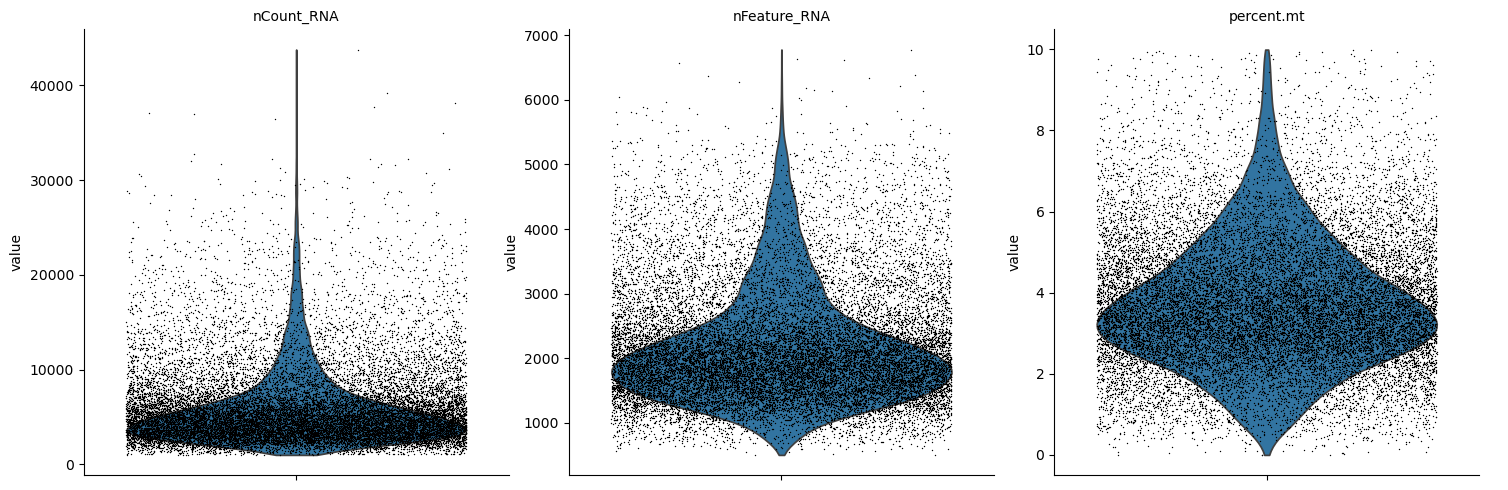

In [81]:
qc_metrics = ['nCount_RNA', 'nFeature_RNA', 'percent.mt']
sc.pl.violin(ad, qc_metrics, jitter=0.4, multi_panel=True)

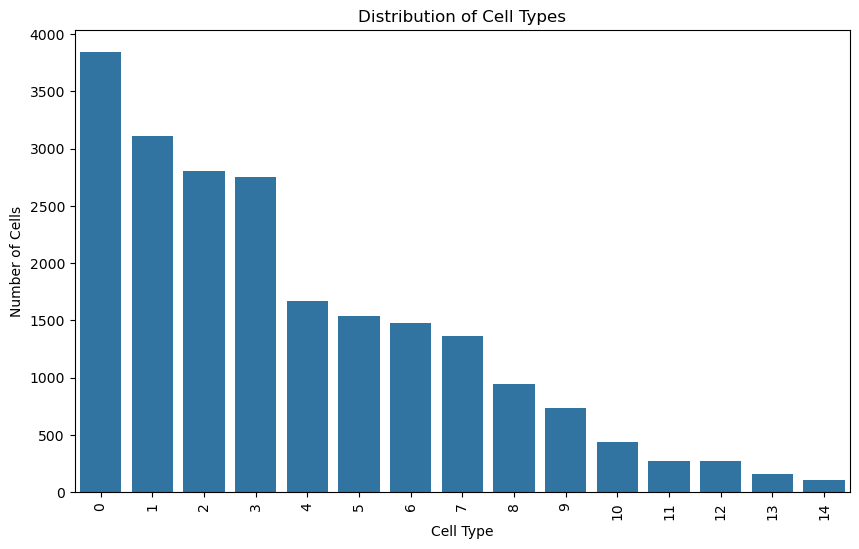

In [82]:
# Bar plot for cell type distribution
celltype_counts = ad.obs['Celltype'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=celltype_counts.index, y=celltype_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cell Types')
plt.show()

In [83]:
# Shift the matrix by adding a constant to make all values non-negative
min_value = np.min(ad.X)
if min_value < 0:
    ad.X += np.abs(min_value)

In [84]:
Y = np.array(ad.X)
X = np.array(ad.obs['Age'])[:, None]

In [85]:
print(X.shape)
print(Y.shape)

(21458, 1)
(21458, 3000)


In [86]:
Y.mean()

8.701774016613367

In [87]:
len(ad.obs['Age_cat'].unique())

26

In [88]:
nmf_model = NMF(n_components=12, max_iter=100, init='random', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [89]:
nmf_model.fit(Y)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=100, n_components=12,
    random_state=0)

In [90]:
W = nmf_model.fit_transform(Y)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [91]:
factors = np.log(np.exp(W) + 1e-2)
loadings = nmf_model.components_.T#*5

In [92]:
ad.obsm['X_nmf'] = W

In [93]:
sc.pp.neighbors(ad, use_rep='X_nmf')
sc.tl.umap(ad)

In [94]:
for i in range(W.shape[1]):
    ad.obs[f'Factor_{i+1}'] = W[:, i]

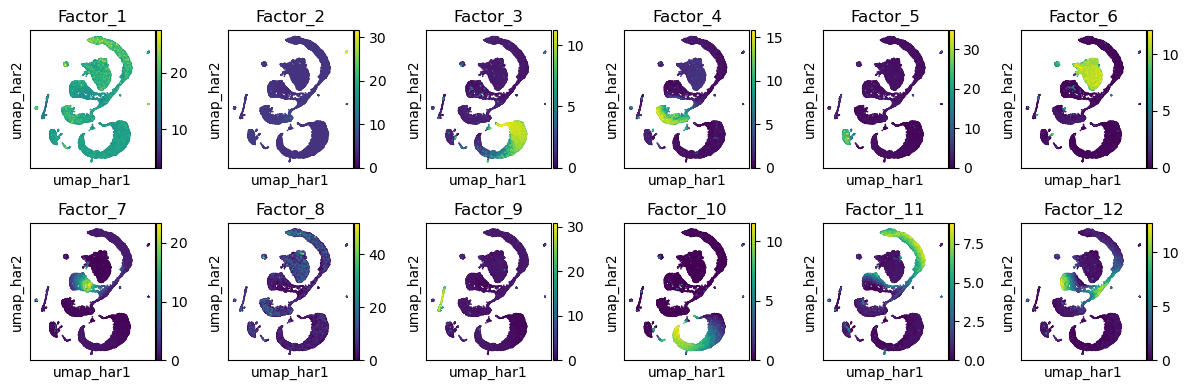

In [95]:
# Check Initialization

L = W.shape[1]
size=2
fig, axes = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)

for i in range(L):
    curr_ax = axes[i//6, i%6]
    sc.pl.embedding(ad, basis='umap_har', color=f'Factor_{i+1}', ax=curr_ax, show=False)

In [113]:
def build_model(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    Parameters:
    X:
        - torch.Size([N, D])
    Y:
        - torch.Size([L, N])
    loadings:
        - torch.Size([L, K])
    factors:
        - torch.Size([N, L])
    """
    V = scanpy_sizefactors(Y.T)
    #X = torch.tensor(X).type(torch.float).to(device)
    #Y = torch.tensor(Y).type(torch.float).to(device)
    kwargs = kwargs['kwargs']

    kmeans = putil.inducing_points_cluster_centers(X, kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
    gp = None
    if model_type == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif model_type == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])

    X = torch.tensor(X).type(torch.float)
    Y = torch.tensor(Y).type(torch.float)
    Kzx = kernel.forward(Z.to('cpu'), X.to('cpu'))
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
    #print(Kzx @ Kxz)
    L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-1)) # changed from 1e-4 to 1e-3
    
    solved1 = torch.cholesky_solve(Kzx @ all_factors, L1)
    mu = (Kzz @ solved1).to(device)
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M'])
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp=gp, y=Y, L=kwargs['L'])

    if loadings is not None:
        model.W = nn.Parameter(torch.tensor(putil.init_softplus(loadings)[:, :kwargs['L']]).type(torch.float))
    model.V = nn.Parameter(torch.squeeze(torch.tensor(putil.init_softplus(V)).type(torch.float)))
    model.to(device)
    return model

In [127]:
L = [10]
M = [3000]
K = [8]
lkzz_builds = [1]
sigmas = [1.0, 1.2]
lengthscales = [2.0, 3.0, 4.0]

In [128]:
model_type = 'VNNGP'
steps = 2000
batched = True
NMF = True

In [129]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y.T, dtype=torch.float)

/tmp/ipykernel_1466928/4213340844.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


In [118]:
X.min()

tensor(3.3000)

In [119]:
X.max()

tensor(29.)

In [120]:
Y.min()

tensor(0.)

In [121]:
Y.max()

tensor(35.5140)

In [123]:
Y = np.log(np.exp(Y) + 1e-2)

In [124]:
Y.min()

0.01980262729617973

In [125]:
Y.max()

51.8900103042166

In [126]:
Y.mean()

2.995297306071998

In [130]:
for k in K:
    for s in sigmas:
        for l in lengthscales:
            dicts = {
                'L': 12, 
                'M': 2176, 
                'K': 8,
                'sigma': s, 
                'lengthscale': l, 
                'jtr': 1e-1,
                'batch_size': 128,
                'lr': 1e-3,
                'rs': 256,
                'lkzz_build': 1,
            }
            
            factors = np.array(factors)
            loadings = np.array(loadings)
            
            kwargs = dicts
            file_path = model_type
            #X, Y = data_func()
            #K=None
            if model_type == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
            
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
                    
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
                
            if NMF:
                # with NMF initialization
                file_path += f"_NMFinit"
                X_array = np.array(X.cpu())
                Y_array = np.array(Y.cpu())
                moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                factors=factors[:, moran_idx]
                loadings=loadings[:, moran_idx]
                model = build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
                    
            #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
            putil.model_grads(model)
            model.prior.jitter=kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
                
            model.to(device)
            X = torch.tensor(X).type(torch.float)
            Y = torch.tensor(Y).type(torch.float)
            X_train = X.to(device)
            #Y_train = Y.to(device)
                
            start_time = time.time()
            X = torch.tensor(X, dtype=torch.float).to(device)
            Y = torch.tensor(Y, dtype=torch.float).to(device)
            losses, means, scales, idxs = putil.train_batched(model, optimizer, X_train, Y, device,
                                                        steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
            end_time = time.time()
                
            final_time = end_time - start_time
                
            torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
            torch.save({'losses': losses,
                        'means': means,
                        'scales': scales,
                        'time': final_time},
                         f'{save_path}/{file_path}_model.pt')
            
            #print('sigmas:', model.prior.kernel.sigma)
            #print('lengthscale:', model.prior.kernel.lengthscale)
            
            fig, ax = plt.subplots()
            ax.plot(losses)
            fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
            
            size=2
            fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                
            model.cpu()
            qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)
            fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
            #fig.savefig(f'{save_path}/{file_path}_plot.png')
            #fig.close()

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (2176). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/tmp/ipykernel_1466928/1192998744.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
/tmp/ipykernel_1466928/1192998744.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y).type(torch.float)


NameError: name 'time' is not defined